# Advanced Lab Version: Data Mining Techniques on Taxi Trips

This advanced version uses a realistic **taxi-trip** dataset instead of image data.

Focus:
- Clustering trip behavior
- Decision trees for trip outcome classification
- Missing data imputation
- Interpretation of model outputs


## 1. Setup


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, classification_report

RANDOM_STATE = 42
sns.set_theme(style="whitegrid", context="notebook")


## 2. Load Local Open-Source Taxi Dataset

Dataset file: `data/taxis.csv` (cached locally for offline runs).


In [2]:
df = pd.read_csv('data/taxis.csv', parse_dates=['pickup', 'dropoff'])

# Feature engineering for trip behavior
df['trip_minutes'] = (df['dropoff'] - df['pickup']).dt.total_seconds() / 60
df = df[df['trip_minutes'] > 0].copy()

df['pickup_hour'] = df['pickup'].dt.hour
df['pickup_weekday'] = df['pickup'].dt.dayofweek

df['tip_pct'] = np.where(df['fare'] > 0, 100 * df['tip'] / df['fare'], 0)
df['high_tip'] = (df['tip_pct'] >= df['tip_pct'].median()).astype(int)

print('Shape:', df.shape)
print('Columns:', list(df.columns))
print('High-tip threshold (median tip %):', round(df['tip_pct'].median(), 2))
df.head()


Shape: (6427, 19)
Columns: ['pickup', 'dropoff', 'passengers', 'distance', 'fare', 'tip', 'tolls', 'total', 'color', 'payment', 'pickup_zone', 'dropoff_zone', 'pickup_borough', 'dropoff_borough', 'trip_minutes', 'pickup_hour', 'pickup_weekday', 'tip_pct', 'high_tip']
High-tip threshold (median tip %): 21.05


,pickup,dropoff,passengers,distance,fare,tip,tolls,total,color,payment,pickup_zone,dropoff_zone,pickup_borough,dropoff_borough,trip_minutes,pickup_hour,pickup_weekday,tip_pct,high_tip
0,2019-03-23 20:21:09,2019-03-23 20:27:24,1,1.60,7.0,2.15,0.0,12.95,yellow,credit card,Lenox Hill West,UN/Turtle Bay South,Manhattan,Manhattan,6.250000,20,5,30.714286,1
1,2019-03-04 16:11:55,2019-03-04 16:19:00,1,0.79,5.0,0.00,0.0,9.30,yellow,cash,Upper West Side South,Upper West Side South,Manhattan,Manhattan,7.083333,16,0,0.000000,0
2,2019-03-27 17:53:01,2019-03-27 18:00:25,1,1.37,7.5,2.36,0.0,14.16,yellow,credit card,Alphabet City,West Village,Manhattan,Manhattan,7.400000,17,2,31.466667,1
3,2019-03-10 01:23:59,2019-03-10 01:49:51,1,7.70,27.0,6.15,0.0,36.95,yellow,credit card,Hudson Sq,Yorkville West,Manhattan,Manhattan,25.866667,1,6,22.777778,1
4,2019-03-30 13:27:42,2019-03-30 13:37:14,3,2.16,9.0,1.10,0.0,13.40,yellow,credit card,Midtown East,Yorkville West,Manhattan,Manhattan,9.533333,13,5,12.222222,0


#### Output Analysis
- Confirm row count and derived columns (`trip_minutes`, `tip_pct`, `high_tip`).
- `high_tip` is a balanced binary target by construction (median split).
- This setup creates a practical supervised task from raw trip records.


## 3. Quick EDA


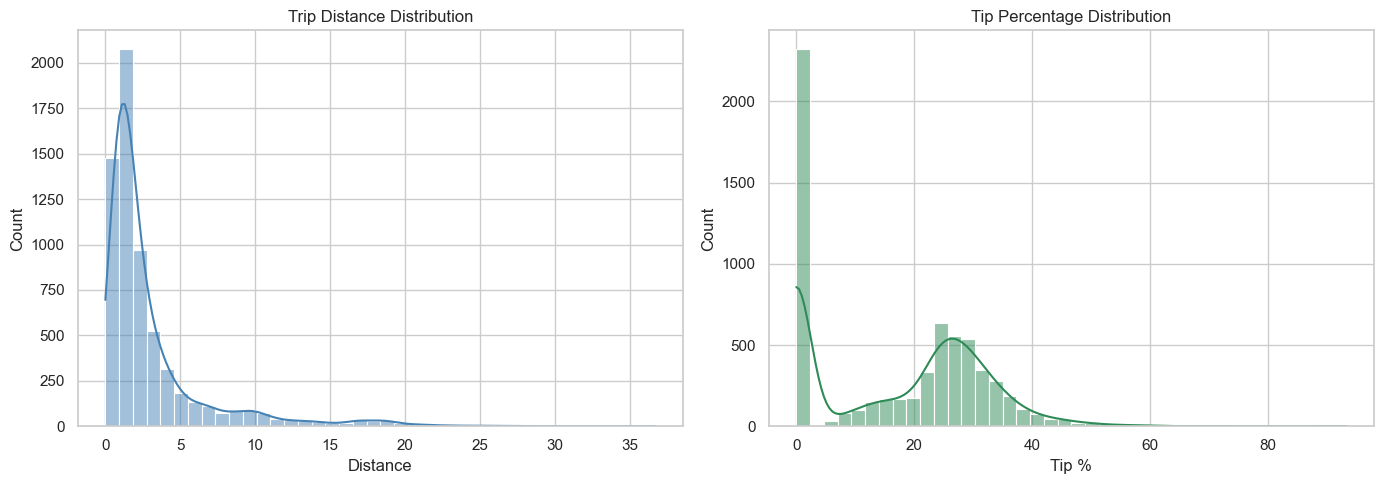

In [3]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

sns.histplot(df['distance'], bins=40, kde=True, ax=axes[0], color='steelblue')
axes[0].set_title('Trip Distance Distribution')
axes[0].set_xlabel('Distance')

sns.histplot(df['tip_pct'], bins=40, kde=True, ax=axes[1], color='seagreen')
axes[1].set_title('Tip Percentage Distribution')
axes[1].set_xlabel('Tip %')

plt.tight_layout()
plt.show()


#### Output Analysis
- Distance and tip distributions are right-skewed, so extreme values exist.
- This motivates scaling for clustering and careful model interpretation.
- Tip percentage variability supports the `high_tip` classification objective.


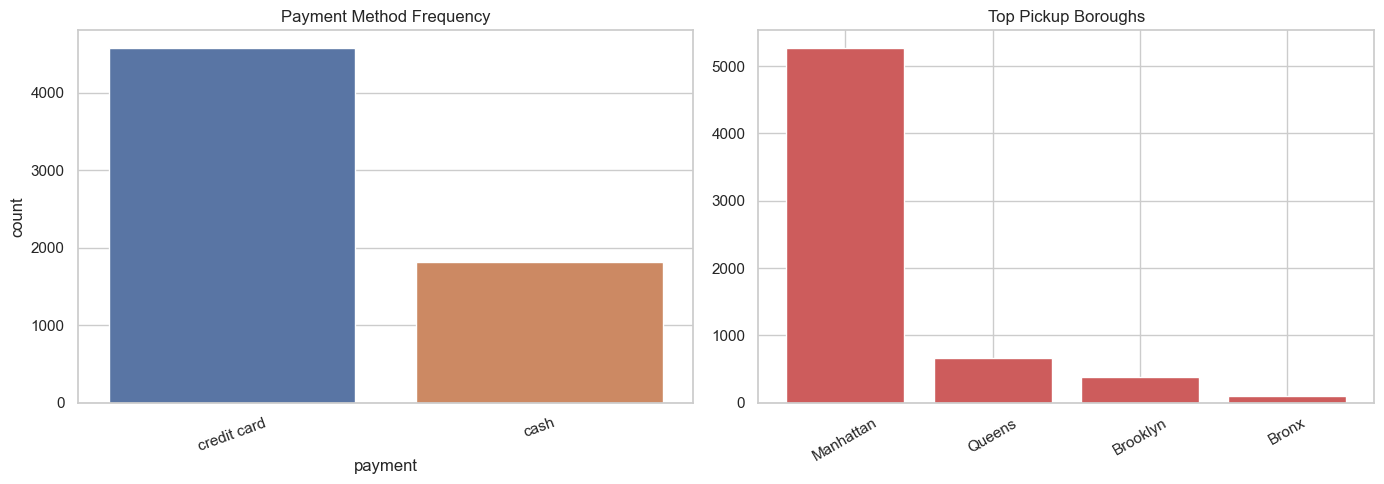

In [4]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

sns.countplot(data=df, x='payment', hue='payment', ax=axes[0], legend=False)
axes[0].set_title('Payment Method Frequency')
axes[0].tick_params(axis='x', rotation=20)

borough_counts = df['pickup_borough'].value_counts().head(8)
axes[1].bar(borough_counts.index.astype(str), borough_counts.values, color='indianred')
axes[1].set_title('Top Pickup Boroughs')
axes[1].tick_params(axis='x', rotation=30)

plt.tight_layout()
plt.show()


#### Output Analysis
- Payment and borough distributions are non-uniform and informative.
- Categorical imbalance is normal for operational mobility datasets.
- These variables may carry predictive signal in tree models.


## 4. Clustering Visualization (K-Means)


In [5]:
cluster_features = ['passengers', 'distance', 'fare', 'tolls', 'trip_minutes', 'pickup_hour', 'pickup_weekday']
X_cluster = df[cluster_features].copy()

scaler = StandardScaler()
X_cluster_scaled = scaler.fit_transform(X_cluster)

kmeans = KMeans(n_clusters=4, random_state=RANDOM_STATE, n_init=20)
cluster_labels = kmeans.fit_predict(X_cluster_scaled)
df['cluster'] = cluster_labels

pca = PCA(n_components=2, random_state=RANDOM_STATE)
X_pca = pca.fit_transform(X_cluster_scaled)

print('Cluster sizes:')
print(pd.Series(cluster_labels).value_counts().sort_index().to_string())

cluster_profile = df.groupby('cluster')[cluster_features].mean().round(2)
cluster_profile


Cluster sizes:
0    2535
1     550
2     510
3    2832


,passengers,distance,fare,tolls,trip_minutes,pickup_hour,pickup_weekday
cluster,,,,,,,
0,1.21,2.01,10.23,0.01,12.10,15.02,1.46
1,1.45,13.15,42.33,3.74,40.15,13.85,2.92
2,5.06,2.32,10.98,0.00,12.76,13.35,3.26
3,1.22,2.10,10.35,0.01,11.67,12.94,4.73


#### Output Analysis
- Compare cluster sizes to check whether K-Means produced meaningful partitions.
- Cluster profile means help interpret segments (e.g., short low-fare trips vs longer expensive trips).
- This is an unsupervised view of behavioral trip archetypes.


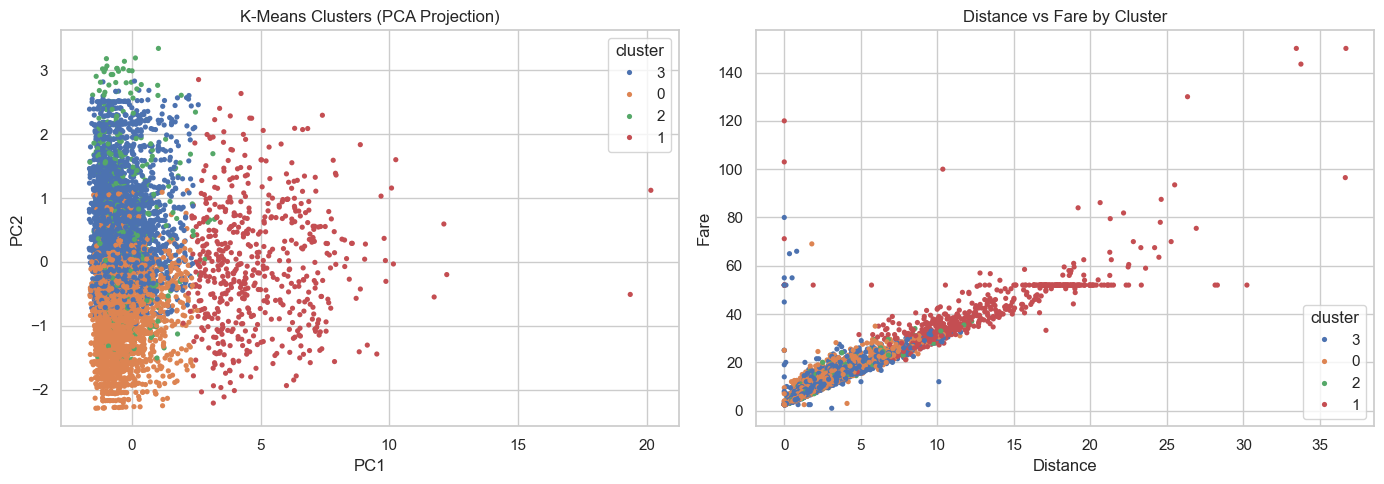

In [6]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=df['cluster'].astype(str), s=14, linewidth=0, ax=axes[0])
axes[0].set_title('K-Means Clusters (PCA Projection)')
axes[0].set_xlabel('PC1')
axes[0].set_ylabel('PC2')

sns.scatterplot(x=df['distance'], y=df['fare'], hue=df['cluster'].astype(str), s=14, linewidth=0, ax=axes[1])
axes[1].set_title('Distance vs Fare by Cluster')
axes[1].set_xlabel('Distance')
axes[1].set_ylabel('Fare')

plt.tight_layout()
plt.show()


#### Output Analysis
- PCA plot shows whether cluster boundaries are separable in reduced space.
- Distance-fare plot provides a business-readable view of cluster behavior.
- If clusters overlap strongly, increasing or changing features may help.


## 5. Decision Trees: Gini vs Entropy


In [7]:
target = 'high_tip'
numeric_features = ['passengers', 'distance', 'fare', 'tolls', 'trip_minutes', 'pickup_hour', 'pickup_weekday']
categorical_features = ['payment', 'color', 'pickup_borough', 'dropoff_borough']

X_tree = df[numeric_features + categorical_features]
y_tree = df[target]

X_train, X_test, y_train, y_test = train_test_split(
    X_tree, y_tree, test_size=0.25, random_state=RANDOM_STATE, stratify=y_tree
)

preprocessor = ColumnTransformer(
    transformers=[
        ('num', Pipeline([('imputer', SimpleImputer(strategy='median'))]), numeric_features),
        ('cat', Pipeline([
            ('imputer', SimpleImputer(strategy='most_frequent')),
            ('onehot', OneHotEncoder(handle_unknown='ignore')),
        ]), categorical_features),
    ]
)

def train_eval_tree(criterion, depth=6):
    model = Pipeline([
        ('prep', preprocessor),
        ('tree', DecisionTreeClassifier(criterion=criterion, max_depth=depth, random_state=RANDOM_STATE)),
    ])
    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    acc = accuracy_score(y_test, preds)
    return model, preds, acc

model_gini, preds_gini, acc_gini = train_eval_tree('gini', depth=6)
model_entropy, preds_entropy, acc_entropy = train_eval_tree('entropy', depth=6)

print(f'Gini accuracy:    {acc_gini:.3f}')
print(f'Entropy accuracy: {acc_entropy:.3f}')


Gini accuracy:    0.823
Entropy accuracy: 0.828


#### Output Analysis
- This comparison is **leakage-safe**: `high_tip` is the target, and tip-derived inputs are excluded.
- Compare Gini vs Entropy accuracy on the same split and feature set.
- Similar scores suggest criterion choice is less influential than feature engineering.


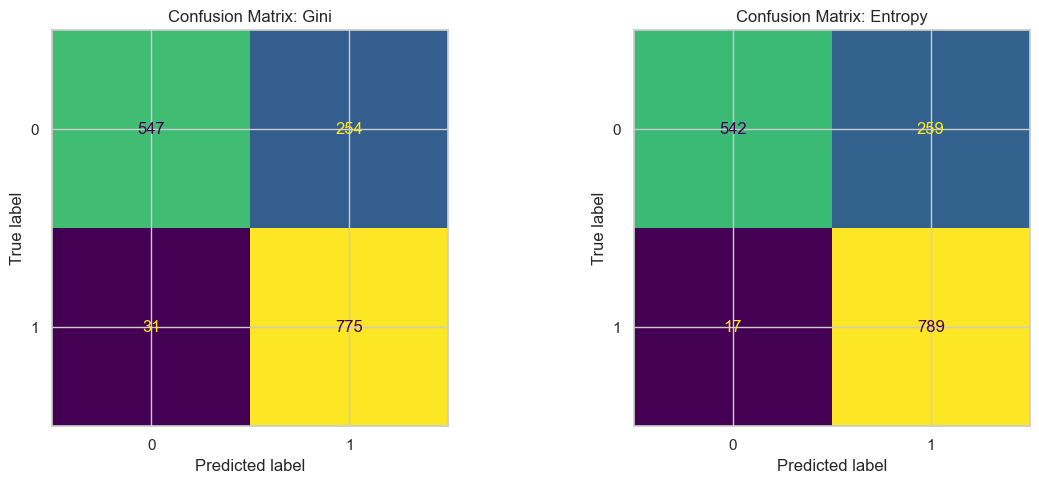

Classification report (Entropy):
              precision    recall  f1-score   support

     low_tip       0.97      0.68      0.80       801
    high_tip       0.75      0.98      0.85       806

    accuracy                           0.83      1607
   macro avg       0.86      0.83      0.82      1607
weighted avg       0.86      0.83      0.82      1607



In [8]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

ConfusionMatrixDisplay(confusion_matrix(y_test, preds_gini)).plot(ax=axes[0], colorbar=False)
axes[0].set_title('Confusion Matrix: Gini')

ConfusionMatrixDisplay(confusion_matrix(y_test, preds_entropy)).plot(ax=axes[1], colorbar=False)
axes[1].set_title('Confusion Matrix: Entropy')

plt.tight_layout()
plt.show()

print('Classification report (Entropy):')
print(classification_report(y_test, preds_entropy, target_names=['low_tip', 'high_tip']))


#### Output Analysis
- Use precision/recall/F1 to understand tradeoffs between catching high-tip trips vs false alarms.
- Accuracy alone can hide class-specific errors.
- In mobility settings, per-class metrics are often more actionable than a single score.


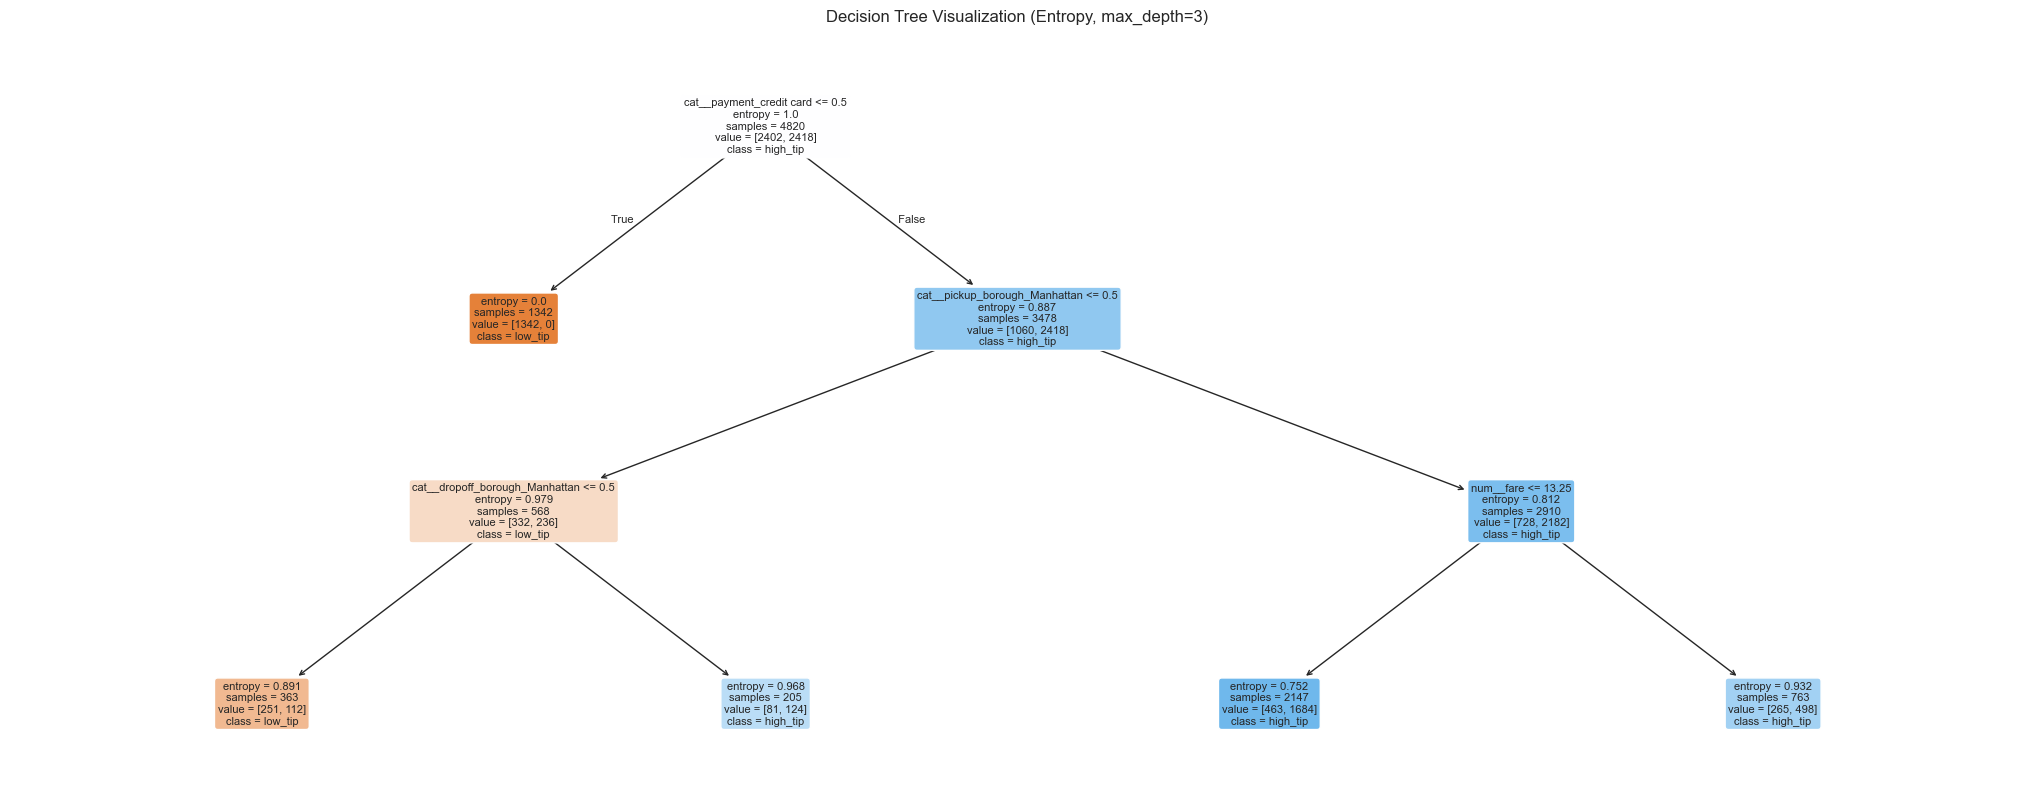

In [9]:
# Train a smaller tree for visualization readability
viz_depth = 3
viz_model = Pipeline([
    ('prep', preprocessor),
    ('tree', DecisionTreeClassifier(criterion='entropy', max_depth=viz_depth, random_state=RANDOM_STATE)),
])
viz_model.fit(X_train, y_train)

prep = viz_model.named_steps['prep']
feature_names = prep.get_feature_names_out()

plt.figure(figsize=(26, 10))
plot_tree(
    viz_model.named_steps['tree'],
    feature_names=feature_names,
    class_names=['low_tip', 'high_tip'],
    filled=True,
    rounded=True,
    fontsize=8,
)
plt.title(f'Decision Tree Visualization (Entropy, max_depth={viz_depth})')
plt.show()


#### Output Analysis
- A shallow tree is easier to explain to non-technical stakeholders.
- First splits reveal what signals (distance, fare, payment, borough) drive high-tip probability.
- This supports interpretable decision support narratives.


## 6. Model Complexity and Overfitting


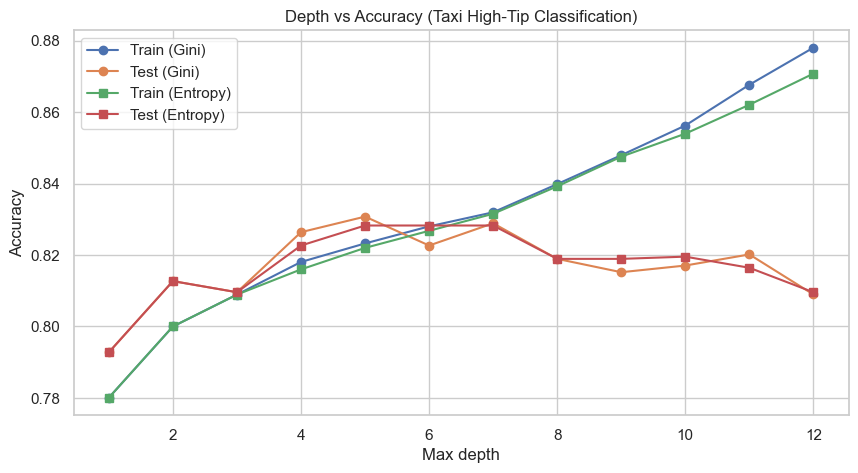

In [10]:
depths = range(1, 13)
train_scores_gini, test_scores_gini = [], []
train_scores_entropy, test_scores_entropy = [], []

for d in depths:
    mg = Pipeline([
        ('prep', preprocessor),
        ('tree', DecisionTreeClassifier(criterion='gini', max_depth=d, random_state=RANDOM_STATE)),
    ])
    me = Pipeline([
        ('prep', preprocessor),
        ('tree', DecisionTreeClassifier(criterion='entropy', max_depth=d, random_state=RANDOM_STATE)),
    ])

    mg.fit(X_train, y_train)
    me.fit(X_train, y_train)

    train_scores_gini.append(mg.score(X_train, y_train))
    test_scores_gini.append(mg.score(X_test, y_test))

    train_scores_entropy.append(me.score(X_train, y_train))
    test_scores_entropy.append(me.score(X_test, y_test))

plt.figure(figsize=(10, 5))
plt.plot(depths, train_scores_gini, marker='o', label='Train (Gini)')
plt.plot(depths, test_scores_gini, marker='o', label='Test (Gini)')
plt.plot(depths, train_scores_entropy, marker='s', label='Train (Entropy)')
plt.plot(depths, test_scores_entropy, marker='s', label='Test (Entropy)')
plt.xlabel('Max depth')
plt.ylabel('Accuracy')
plt.title('Depth vs Accuracy (Taxi High-Tip Classification)')
plt.legend()
plt.show()


#### Output Analysis
- Divergence between train and test curves indicates overfitting.
- Choose depth near peak test accuracy, not maximum train accuracy.
- This is a core model-selection lesson from Lecture 7.2.


## 7. Feature Importance


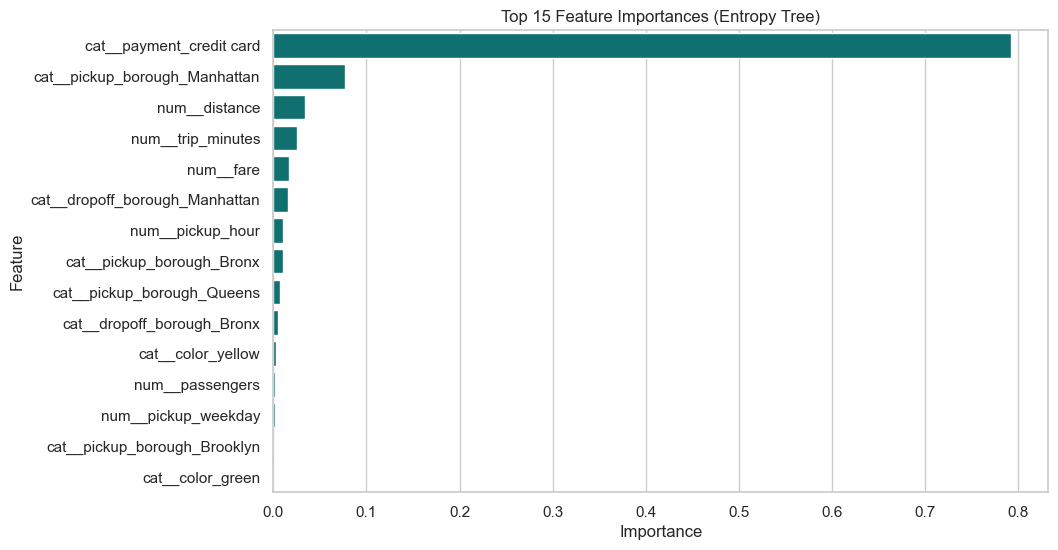

cat__payment_credit card          0.792847
cat__pickup_borough_Manhattan     0.076459
num__distance                     0.034469
num__trip_minutes                 0.025748
num__fare                         0.016413
cat__dropoff_borough_Manhattan    0.015624
num__pickup_hour                  0.010209
cat__pickup_borough_Bronx         0.009958
cat__pickup_borough_Queens        0.006879
cat__dropoff_borough_Bronx        0.005276
cat__color_yellow                 0.002445
num__passengers                   0.002161
num__pickup_weekday               0.001512
cat__pickup_borough_Brooklyn      0.000000
cat__color_green                  0.000000
dtype: float64

In [11]:
entropy_tree = model_entropy.named_steps['tree']
feature_names = model_entropy.named_steps['prep'].get_feature_names_out()
importance = pd.Series(entropy_tree.feature_importances_, index=feature_names).sort_values(ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x=importance.head(15).values, y=importance.head(15).index, color='teal')
plt.title('Top 15 Feature Importances (Entropy Tree)')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()

importance.head(15)


#### Output Analysis
- Top features indicate what most influences high-tip outcomes.
- Compare whether numeric trip signals or categorical context signals dominate.
- This guides feature-selection and business interpretation.


## 8. Missing Data and Imputation Techniques


In [12]:
# Numeric-only imputation experiment for clean method comparison
# Note: we exclude tip-derived fields (`tip`, `total`, `tip_pct`) to avoid target leakage.
num_cols = ['passengers', 'distance', 'fare', 'tolls', 'trip_minutes', 'pickup_hour', 'pickup_weekday']
X_num = df[num_cols].copy()
y_num = df['high_tip']

missing_rate = 0.10
rng = np.random.default_rng(RANDOM_STATE)
X_num_missing = X_num.mask(rng.random(X_num.shape) < missing_rate)

missing_total = int(X_num_missing.isna().sum().sum())
missing_pct = 100 * missing_total / X_num_missing.size
print(f'Missing cells: {missing_total} ({missing_pct:.1f}%)')

X_num_missing.isna().mean().sort_values(ascending=False)


Missing cells: 4446 (9.9%)


distance          0.100202
fare              0.099891
passengers        0.099580
trip_minutes      0.098335
pickup_hour       0.098335
tolls             0.098180
pickup_weekday    0.097246
dtype: float64

#### Output Analysis
- Random missingness near 10% gives a controlled comparison setup.
- Feature-wise missing rates vary slightly due to randomness.
- Because tip-derived fields are excluded, imputation results reflect realistic pre-tip signals.


In [13]:
X_train_m, X_test_m, y_train_m, y_test_m = train_test_split(
    X_num_missing, y_num, test_size=0.25, random_state=RANDOM_STATE, stratify=y_num
)

imputers = {
    'mean': SimpleImputer(strategy='mean'),
    'median': SimpleImputer(strategy='median'),
    'most_frequent': SimpleImputer(strategy='most_frequent'),
    'knn': KNNImputer(n_neighbors=5),
}

rows = []
for name, imputer in imputers.items():
    Xtr = imputer.fit_transform(X_train_m)
    Xte = imputer.transform(X_test_m)

    clf = DecisionTreeClassifier(criterion='entropy', max_depth=6, random_state=RANDOM_STATE)
    clf.fit(Xtr, y_train_m)
    preds = clf.predict(Xte)

    rows.append({
        'imputer': name,
        'accuracy': accuracy_score(y_test_m, preds),
        'remaining_missing_train': int(np.isnan(Xtr).sum()),
        'remaining_missing_test': int(np.isnan(Xte).sum()),
    })

imputation_results = pd.DataFrame(rows).sort_values('accuracy', ascending=False)
imputation_results


,imputer,accuracy,remaining_missing_train,remaining_missing_test
1,median,0.552582,0,0
2,most_frequent,0.550093,0,0
0,mean,0.548849,0,0
3,knn,0.538892,0,0


#### Output Analysis
- Compare imputers by test accuracy and verify remaining missing counts are zero.
- Without leakage features, accuracy differences are usually smaller and more realistic.
- This gives a cleaner estimate of imputation impact on predictive quality.


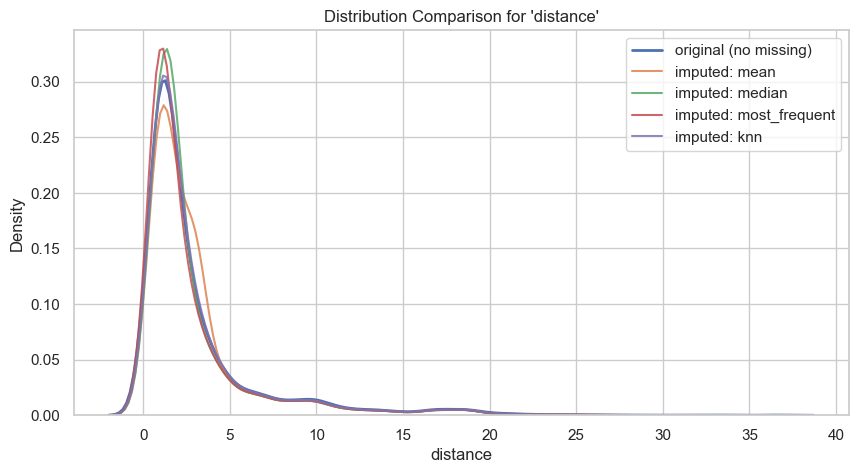

In [14]:
feature = 'distance'
feature_idx = X_num.columns.get_loc(feature)

plt.figure(figsize=(10, 5))
sns.kdeplot(X_num[feature], label='original (no missing)', linewidth=2)

for name, imputer in imputers.items():
    X_imp_full = imputer.fit_transform(X_num_missing)
    sns.kdeplot(X_imp_full[:, feature_idx], label=f'imputed: {name}', alpha=0.85)

plt.title(f"Distribution Comparison for '{feature}'")
plt.xlabel(feature)
plt.ylabel('Density')
plt.legend()
plt.show()


#### Output Analysis
- Distribution shifts reveal whether an imputer distorts realistic trip distances.
- Similar accuracy with different distribution drift should be interpreted carefully.
- Use both predictive and data-quality criteria when selecting an imputation strategy.


## 9. Variant Tasks for 10 Students (Taxi)

### Variant 1
1. Change K-Means clusters from 4 to 3 and 5.
2. Compare cluster sizes and profile means.
3. Explain which `k` yields clearer trip segments.

### Variant 2
1. Add/remove temporal features (`pickup_hour`, `pickup_weekday`) in clustering.
2. Re-run clustering and compare profiles.
3. Explain how this changes cluster interpretation.

### Variant 3
1. Compare `gini` and `entropy` at depths 4, 6, 8.
2. Summarize accuracy and F1 in a table.
3. Pick a best criterion-depth pair.

### Variant 4
1. Add/remove one categorical feature (e.g., borough fields).
2. Retrain entropy tree.
3. Report metric changes and interpretation impact.

### Variant 5
1. Tune depth from 1 to 15.
2. Mark the best test-accuracy depth.
3. Explain overfitting behavior in 4-5 sentences.

### Variant 6
1. Increase missing rate to 20%.
2. Re-run imputation comparison.
3. Identify which method is most robust.

### Variant 7
1. Test `KNNImputer` with neighbors 3, 5, 9.
2. Compare accuracy and runtime.
3. Recommend one setting.

### Variant 8
1. Compare distribution drift for `fare` and `trip_minutes`.
2. Identify which imputer preserves each best.
3. Explain why preserving shape matters.

### Variant 9
1. Keep only top-10 important features.
2. Retrain the entropy model.
3. Compare performance vs full feature set.

### Variant 10
1. Build one summary table for clustering, classification, and imputation.
2. Propose a final pipeline for high-tip prediction.
3. Write a short business-facing conclusion.
